In [7]:
import pandas as pd
import numpy as np
import ast
from textblob import TextBlob

import numpy as np
from sklearn.metrics import f1_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import matplotlib.pyplot as plt

import textstat
import spacy



In [ ]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [2]:
data=pd.read_csv("cleaned_data.csv")

In [3]:
data['lemmatized_tokens'] = data['lemmatized_tokens'].apply(ast.literal_eval)

In [13]:
def get_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

data['sentiment'] = data['rating'].apply(get_sentiment)

In [17]:
### Will do the feature engineering on the lemetized column 
# [always do feature engineering on the preprossesed column]

In [21]:
### ADDING TOTAL char_count,word_count and average_word_length COLUMN TO THE DATASET

# Total number of characters across all clean tokens
data['char_count'] = data['lemmatized_tokens'].apply(lambda x: sum(len(word) for word in x))
data['word_count'] = data['lemmatized_tokens'].apply(lambda x: len(x))
data['avg_word_length'] = data['lemmatized_tokens'].apply(lambda x: (sum(len(word) for word in x) / len(x)) if len(x) > 0 else 0)

# Total number of characters across all raw reviews
# data['char_count'] = data['review'].apply(len)
# data['word_count'] = data['review'].apply(lambda x: len(x.split()))
# data['avg_word_length'] = data['review'].apply(lambda x: np.mean([len(w) for w in x.split()]))


In [8]:
### GETTING THE SENTIMENT POLARITY AND THE SUBJECTIVITY
## applied this to the raw review column because getting the real polarity and subjectivity form the raw column 
## is better then getting it from the raw columns.

# applying textblob on review column
data['sentiment_polarity'] = data['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['sentiment_subjectivity'] = data['review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# applying textblob on title column
data['sentiment_polarity_2'] = data['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['sentiment_subjectivity_2'] = data['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [10]:
## VADER

In [16]:
## Finding the best weight for the combined column of the title and review, using f1_score
## Creating the "vader_weighted_avg" column.

analyzer = SentimentIntensityAnalyzer()

# Vader scores
data['vader_title'] = data['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data['vader_review'] = data['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# True labels
y_true = data['sentiment']  # Replace with your actual sentiment column

# Store best score and weight
best_score = 0
best_weight = 0

# Weight range
weights = np.arange(0.1, 0.91, 0.05)
f1_scores = []

# Loop through weights with tqdm progress bar
for w in tqdm(weights, desc="Optimizing weight"):
    data['vader_weighted_avg'] = (w * data['vader_title']) + ((1 - w) * data['vader_review'])
    
    data['predicted_sentiment'] = data['vader_weighted_avg'].apply(
        lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
    )
    
    f1 = f1_score(y_true, data['predicted_sentiment'], average='weighted')
    f1_scores.append(f1)
    
    if f1 > best_score:
        best_score = f1
        best_weight = w

print(f"Best weight for Title: {best_weight:.2f}")
print(f"Best validation F1 Score: {best_score:.4f}")

# Final columns using best weight
data['vader_weighted_avg'] = (best_weight * data['vader_title']) + ((1 - best_weight) * data['vader_review'])
data['predicted_sentiment'] = data['vader_weighted_avg'].apply(
    lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
)

Optimizing weight: 100%|██████████| 17/17 [00:02<00:00,  7.37it/s]

Best weight for Title: 0.65
Best validation F1 Score: 0.8703


In [ ]:
## Ploting the f1_score against weights

plt.figure(figsize=(8,5))
plt.plot(weights, f1_scores, marker='o', linestyle='-', color='blue')
plt.title('Weight vs F1 Score')
plt.xlabel('Weight for Title')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [21]:
## "flesch_reading_ease"-->ease of readability of a review, higher-easily understandable,lower-complex
## "flesch_kincaid_grade"--> based on US grade level,  higher-easily understandable,lower-complex

data['flesch_reading_ease'] = data['review'].apply(textstat.flesch_reading_ease)
data['flesch_kincaid_grade'] = data['review'].apply(textstat.flesch_kincaid_grade)

In [22]:
## POS Tagging

In [23]:
# import nltk
# nltk.download('averaged_perceptron_tagger')
# from nltk import pos_tag, word_tokenize

# def count_pos(text, pos_tag_prefix):
#     tokens = word_tokenize(text)
#     pos_tags = pos_tag(tokens)
#     return sum(1 for word, tag in pos_tags if tag.startswith(pos_tag_prefix))

# data['noun_count'] = data['review'].apply(lambda x: count_pos(x, 'NN'))
# data['verb_count'] = data['review'].apply(lambda x: count_pos(x, 'VB'))
# data['adj_count'] = data['review'].apply(lambda x: count_pos(x, 'JJ'))


In [25]:
def extract_pos_counts(texts):
    noun_counts, verb_counts, adj_counts = [], [], []
    
    for doc in nlp.pipe(texts, batch_size=50):  # batches the texts
        noun_counts.append(sum(1 for token in doc if token.pos_ == 'NOUN'))
        verb_counts.append(sum(1 for token in doc if token.pos_ == 'VERB'))
        adj_counts.append(sum(1 for token in doc if token.pos_ == 'ADJ'))
    
    return noun_counts, verb_counts, adj_counts

# Apply in batch
nouns, verbs, adjs = extract_pos_counts(data['review'])

data['noun_count'] = nouns
data['verb_count'] = verbs
data['adj_count'] = adjs


In [26]:
def count_entities(text, label):
    doc = nlp(text)
    return sum(1 for ent in doc.ents if ent.label_ == label)

data['person_count'] = data['review'].apply(lambda x: count_entities(x, 'PERSON'))
data['org_count'] = data['review'].apply(lambda x: count_entities(x, 'ORG'))
data['gpe_count'] = data['review'].apply(lambda x: count_entities(x, 'GPE'))


In [27]:
## LDA

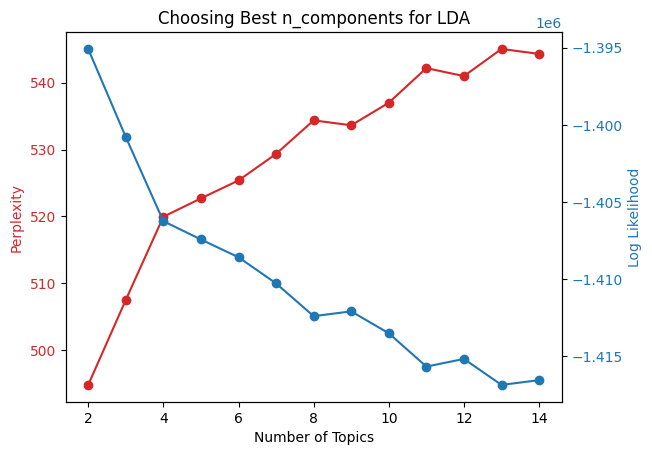

In [36]:
## Getting the best components for making the columns for topics in the dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Convert token lists to space-joined strings
data['lemmatized_text'] = data['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# Vectorize text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['lemmatized_text'])

perplexities = []
log_likelihoods = []
n_topics_range = range(2, 15)  # Try from 2 topics to 14 topics

for n_topics in n_topics_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    
    perplexities.append(lda.perplexity(X))
    log_likelihoods.append(lda.score(X))

# Plot
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(n_topics_range, perplexities, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Log Likelihood', color=color)
ax2.plot(n_topics_range, log_likelihoods, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Choosing Best n_components for LDA')
plt.show()


In [71]:
### function to find the n_components programatically

# from kneed import KneeLocator

# def find_best_n_components(n_topics_range, perplexities, log_likelihoods, method='perplexity'):
#     """
#     Automatically find the elbow/knee point from perplexity or log-likelihood scores.
    
#     Parameters:
#     - n_topics_range: list of integers (e.g., [5, 10, 15, 20, 25])
#     - perplexities: list of perplexity scores
#     - log_likelihoods: list of log-likelihood scores
#     - method: 'perplexity' (default) or 'log_likelihood'
    
#     Returns:
#     - Best number of topics (n_components)
#     """
#     if method == 'perplexity':
#         # Lower is better — looking for minimum curve
#         kneedle = KneeLocator(n_topics_range, perplexities, curve='convex', direction='decreasing')
#     elif method == 'log_likelihood':
#         # Higher is better — looking for maximum curve
#         kneedle = KneeLocator(n_topics_range, log_likelihoods, curve='concave', direction='increasing')
#     else:
#         raise ValueError("Method must be either 'perplexity' or 'log_likelihood'.")

#     print(f"Detected best n_components based on {method}: {kneedle.knee}")
#     return kneedle.knee


# best_n = find_best_n_components(n_topics_range, perplexities, log_likelihoods, method='perplexity')
# # or
# best_n = find_best_n_components(n_topics_range, perplexities, log_likelihoods, method='log_likelihood')


In [37]:
### CREATING THE TOPICS USING THE BEST N_COMPONENTS FROM THE FORMER CODE

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Vectorize the text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(data['lemmatized_text'])

# Step 2: Fit LDA model
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(doc_term_matrix)

# Step 3: Get topic distributions for each document
topic_distributions = lda.transform(doc_term_matrix)

# Step 4: Add each topic's weight as a feature
for i in range(topic_distributions.shape[1]):
    data[f'topic_{i}'] = topic_distributions[:, i]


In [41]:
## SPELLING ERROR 

In [43]:
from spellchecker import SpellChecker

spell = SpellChecker()

def count_spelling_errors(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled)

data['count_of_spelling_errors'] = data['review'].apply(count_spelling_errors)

In [39]:
## EXTRACTING THE DATA INTO A CSV WITH THE FEATURES FOR APPYING IT TO OUR PREVIOUS MACHINE LEARNING MODELS

In [44]:
data.to_csv("data_feature_engineered.csv")